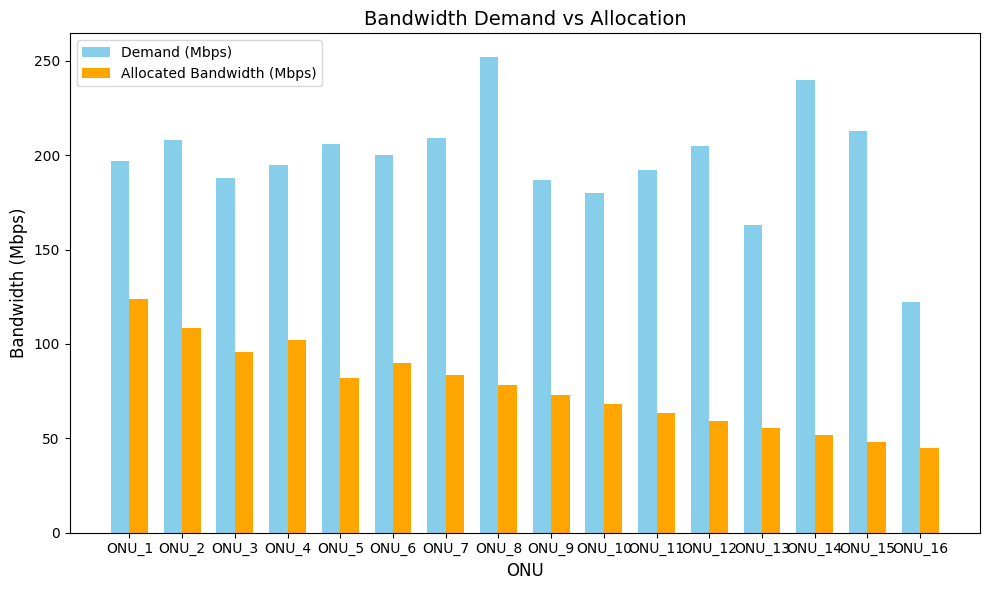

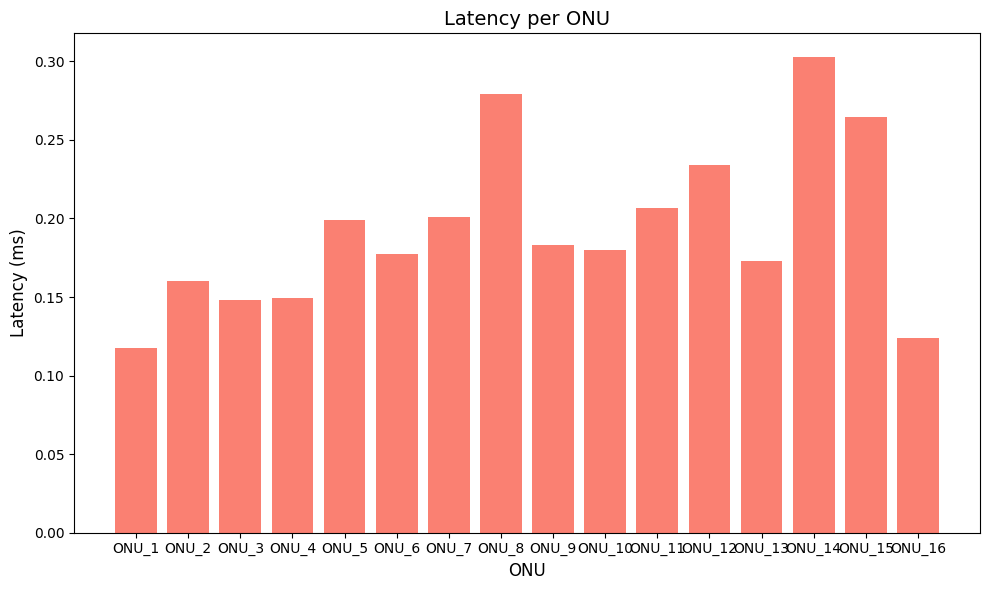

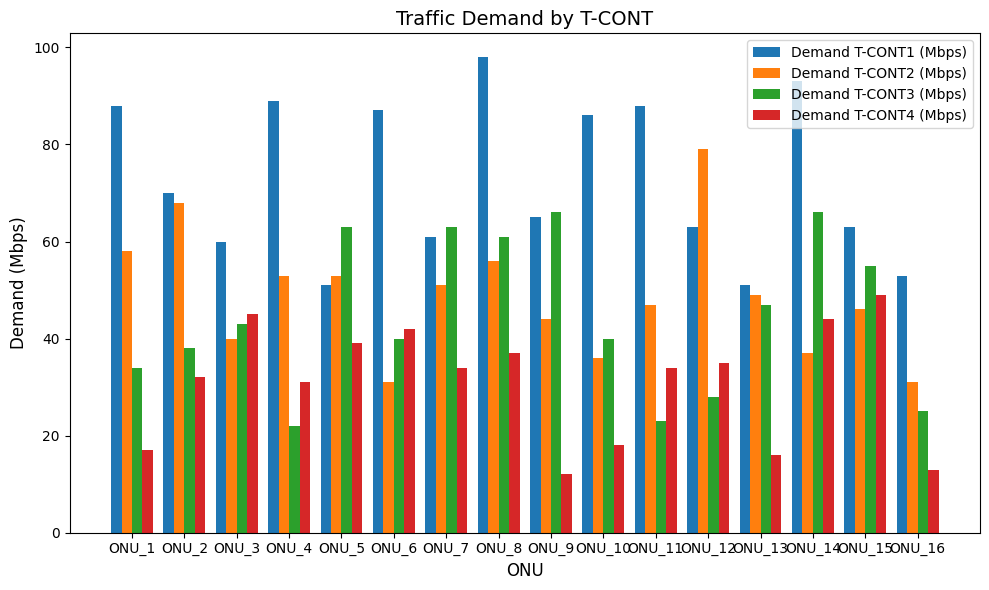

In [2]:
import numpy as np
import pandas as pd

# Parámetros de la simulación
NUM_ONUs = 16  # Número de ONUs
OLT_BANDWIDTH = 1244.16  # Mbps (capacidad total de GPON)
CYCLE_TIME = 2  # ms (tiempo de ciclo de sondeo)

# Demandas de tráfico por ONU y T-CONT (en Mbps)
np.random.seed(42)
traffic_demands = {
    f"ONU_{i+1}": {
        "T-CONT1": np.random.randint(50, 100),  # Alta prioridad
        "T-CONT2": np.random.randint(30, 80),  # Garantizado
        "T-CONT3": np.random.randint(20, 70),  # Best-effort
        "T-CONT4": np.random.randint(10, 50),  # No garantizado
    }
    for i in range(NUM_ONUs)
}

# Función para calcular asignación de ancho de banda y latencias
def dynamic_bandwidth_allocation(demands, bandwidth, cycle_time):
    # Inicializar resultados
    allocations = {}
    latencies = {}
    remaining_bandwidth = bandwidth  # Ancho de banda disponible

    # Asignación de T-CONTs por prioridad
    for priority in ["T-CONT1", "T-CONT2", "T-CONT3", "T-CONT4"]:
        for onu, demand in demands.items():
            if onu not in allocations:
                allocations[onu] = 0
                latencies[onu] = 0

            # Asignar ancho de banda según demanda y disponibilidad
            allocation = min(demand[priority], remaining_bandwidth / (NUM_ONUs - list(allocations.keys()).count(onu)))
            allocations[onu] += allocation
            remaining_bandwidth -= allocation

            # Calcular latencia como el tiempo de espera en el ciclo
            latencies[onu] += (demand[priority] - allocation) / bandwidth * cycle_time

    return allocations, latencies

# Realizar la asignación
allocations, latencies = dynamic_bandwidth_allocation(traffic_demands, OLT_BANDWIDTH, CYCLE_TIME)

# Mostrar resultados
allocations_df = pd.DataFrame(allocations.items(), columns=["ONU", "Assigned Bandwidth (Mbps)"])
latencies_df = pd.DataFrame(latencies.items(), columns=["ONU", "Latency (ms)"])
results_df = pd.merge(allocations_df, latencies_df, on="ONU")

import matplotlib.pyplot as plt

# Crear gráficos
def plot_bandwidth_allocation(demands, allocations):
    # Gráfico de asignación de ancho de banda
    onu_labels = list(demands.keys())
    demand_totals = [sum(demands[onu].values()) for onu in onu_labels]
    allocation_totals = [allocations[onu] for onu in onu_labels]

    x = np.arange(len(onu_labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, demand_totals, width, label='Demand (Mbps)', color='skyblue')
    ax.bar(x + width/2, allocation_totals, width, label='Allocated Bandwidth (Mbps)', color='orange')

    ax.set_xlabel('ONU', fontsize=12)
    ax.set_ylabel('Bandwidth (Mbps)', fontsize=12)
    ax.set_title('Bandwidth Demand vs Allocation', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(onu_labels)
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_latencies(latencies):
    # Gráfico de latencias
    onu_labels = list(latencies.keys())
    latency_values = list(latencies.values())

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(onu_labels, latency_values, color='salmon')
    ax.set_xlabel('ONU', fontsize=12)
    ax.set_ylabel('Latency (ms)', fontsize=12)
    ax.set_title('Latency per ONU', fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_traffic_demands(demands):
    # Gráfico de demanda por T-CONT
    onu_labels = list(demands.keys())
    tconts = list(next(iter(demands.values())).keys())

    demand_matrix = np.array([[demands[onu][tcont] for tcont in tconts] for onu in onu_labels])

    x = np.arange(len(onu_labels))
    width = 0.2

    fig, ax = plt.subplots(figsize=(10, 6))
    for i, tcont in enumerate(tconts):
        ax.bar(x + i*width - (len(tconts)-1)*width/2, demand_matrix[:, i], width, label=f'Demand {tcont} (Mbps)')

    ax.set_xlabel('ONU', fontsize=12)
    ax.set_ylabel('Demand (Mbps)', fontsize=12)
    ax.set_title('Traffic Demand by T-CONT', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(onu_labels)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Generar gráficos
plot_bandwidth_allocation(traffic_demands, allocations)
plot_latencies(latencies)
plot_traffic_demands(traffic_demands)

